📌 Overview
# This notebook trains and evaluates various machine learning models to predict health status (is_healthy). The best-performing model is Logistic Regression, and we visualize its decision boundary.

# **Install Necessary packages and libraries**

In [ ]:
!pip install catboost

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
from google.colab import drive

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Scikit-learn version: 1.6.1
XGBoost version: 2.1.3
LightGBM version: 4.5.0


# **Load the data**

In [72]:
from google.colab import files
import pandas as pd

uploaded = files.upload()  # Opens file selection dialog
filename = list(uploaded.keys())[0]  # Get the filename
df = pd.read_csv(filename)  # Read the CSV file into a DataFrame

print(f"Loaded dataset: {filename}")
df.head()


Saving innovize_final_ml.csv to innovize_final_ml.csv
Loaded dataset: innovize_final_ml.csv


,phy_fitness,diet_pref,act_level,sleep_hrs,mindfulness,career,gender,daily_avg_steps,daily_avg_calories,is_healthy
0,3.0,Vegan,Sedentary,7,10,Artist,1.0,2020.0,1831.0,0
1,4.0,Vegan,Lightly Active,7,1,Teacher,0.0,5154.0,2190.0,0
2,8.0,Vegetarian,Active,8,10,Freelancer,1.0,12363.0,2297.0,1
3,2.0,Pescatarian,Sedentary,8,7,Doctor,0.0,1664.0,1943.0,0
4,9.0,Pescatarian,Highly Active,5,7,Business,0.0,17680.0,3527.0,1


# **Explore the data**

In [73]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   phy_fitness         5997 non-null   float64
 1   diet_pref           5996 non-null   object 
 2   act_level           5994 non-null   object 
 3   sleep_hrs           6000 non-null   int64  
 4   mindfulness         6000 non-null   int64  
 5   career              5996 non-null   object 
 6   gender              5999 non-null   float64
 7   daily_avg_steps     5989 non-null   float64
 8   daily_avg_calories  5986 non-null   float64
 9   is_healthy          6000 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 468.9+ KB
None


In [ ]:
print(df.describe())

       phy_fitness    sleep_hrs  mindfulness       gender  daily_avg_steps  \
count  5997.000000  6000.000000  6000.000000  5999.000000      5989.000000   
mean      5.440554     7.010333     5.570667     0.507085      9034.638671   
std       2.888524     1.413822     2.876581     0.499991      5525.278444   
min       1.000000     5.000000     1.000000     0.000000      1001.000000   
25%       3.000000     6.000000     3.000000     0.000000      4178.000000   
50%       5.000000     7.000000     6.000000     1.000000      8162.000000   
75%       8.000000     8.000000     8.000000     1.000000     13598.000000   
max      10.000000     9.000000    10.000000     1.000000     20000.000000   

       daily_avg_calories   is_healthy  
count         5986.000000  6000.000000  
mean          2390.541764     0.315333  
std            638.908131     0.464687  
min           1500.000000     0.000000  
25%           1889.000000     0.000000  
50%           2243.500000     0.000000  
75%       

In [ ]:
print(df.isnull().sum())  # Check missing values

phy_fitness            3
diet_pref              4
act_level              6
sleep_hrs              0
mindfulness            0
career                 4
gender                 1
daily_avg_steps       11
daily_avg_calories    14
is_healthy             0
dtype: int64


# **Preprocessing**

In [74]:
# Handle missing values
df.dropna(inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('is_healthy')
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# **Train-Test Split**

In [75]:
# Split dataset
X = df.drop(columns=['is_healthy'])
y = df['is_healthy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [77]:
# Hyperparameter tuning
param_grid = {
       'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'LightGBM': {'num_leaves': [31, 50], 'learning_rate': [0.01, 0.1]},
    'CatBoost': {'depth': [6, 8, 10], 'iterations': [100, 200]},
   # 'Neural Network': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh']},
    #'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9]}
}


In [78]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
   # "Neural Network": MLPClassifier(max_iter=500),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


# **Train Multiple Models & Hyperparameter Tuning**

*  Trains multiple models using hyperparameter tuning (GridSearchCV).
* Selects the best model based on accuracy.
* Prints the best model and its accuracy.

In [79]:
best_model = None
best_score = 0

for name, model in models.items():
    try:
        grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=cv, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model_instance = grid_search.best_estimator_
        scores = cross_val_score(best_model_instance, X_train, y_train, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        print(f"{name} Cross-Validated Accuracy: {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_model = best_model_instance
    except Exception as e:
        print(f"Error training {name}: {e}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Logistic Regression Cross-Validated Accuracy: 0.9992
Random Forest Cross-Validated Accuracy: 0.9811
[LightGBM] [Info] Number of positive: 1530, number of negative: 3241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 4771, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320687 -> initscore=-0.750614
[LightGBM] [Info] Start training from score -0.750614
[LightGBM] [Info] Number of positive: 1224, number of negative: 2592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] N

In [80]:
# Save the best model locally
model_path = 'best_health_model.pkl'
joblib.dump(best_model, model_path)
print(f"Best model saved at: {model_path}")

Best model saved at: best_health_model.pkl


# **Performance Evaluation of the best model**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       353

    accuracy                           1.00      1193
   macro avg       1.00      1.00      1.00      1193
weighted avg       1.00      1.00      1.00      1193



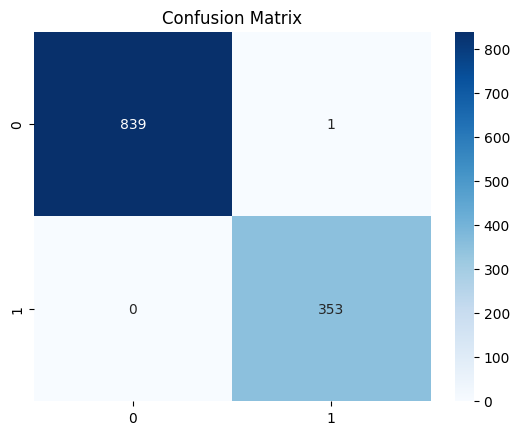

In [81]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# **Visualize ROC Curve**

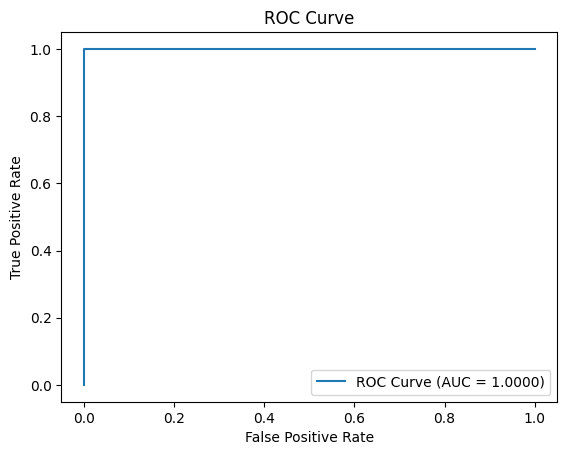

In [82]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_prob)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# **Visualize Decision Boundary**

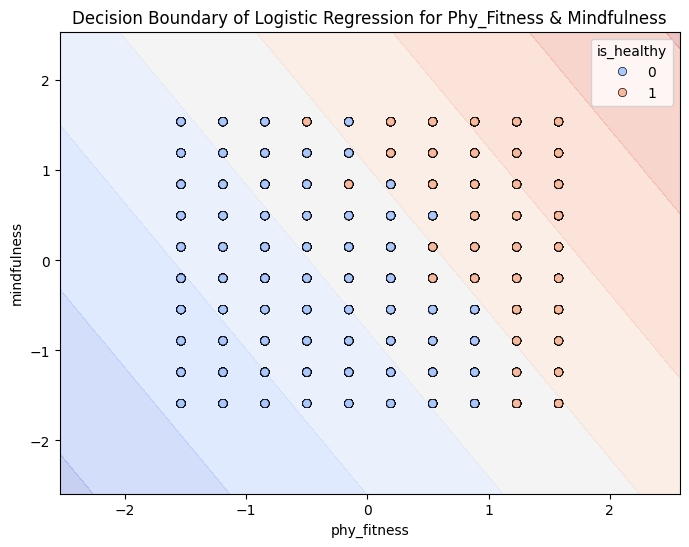

In [ ]:
best_params = {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

X = df.drop(columns=['is_healthy'])
y = df['is_healthy']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_model = LogisticRegression(**best_params)
best_model.fit(X_scaled, y)

feature_1 = 'phy_fitness'
feature_2 = 'mindfulness'


X_vis = df[[feature_1, feature_2]]

scaler_vis = StandardScaler()
X_vis_scaled = scaler_vis.fit_transform(X_vis)

vis_model = LogisticRegression(**best_params)
vis_model.fit(X_vis_scaled, y)

x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = vis_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

sns.scatterplot(x=X_vis_scaled[:, 0], y=X_vis_scaled[:, 1], hue=y, edgecolor='k', palette='coolwarm')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title('Decision Boundary of Logistic Regression for Phy_Fitness & Mindfulness')
plt.show()


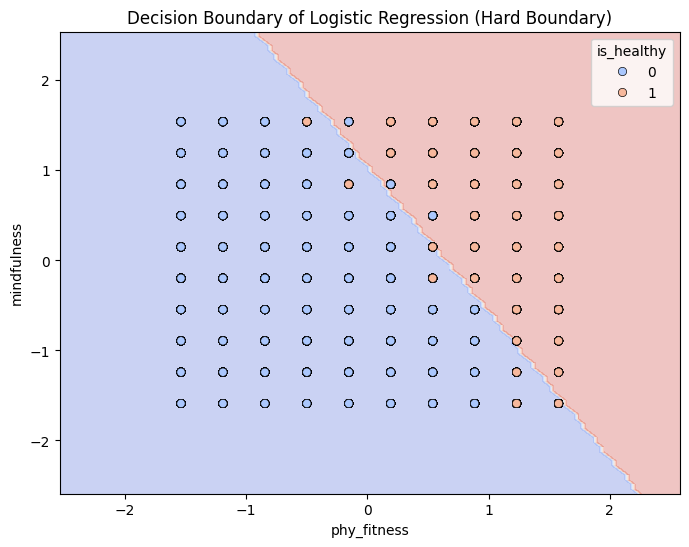

In [ ]:
Z = vis_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

sns.scatterplot(x=X_vis_scaled[:, 0], y=X_vis_scaled[:, 1], hue=y, edgecolor='k', palette='coolwarm')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title('Decision Boundary of Logistic Regression (Hard Boundary)')
plt.show()
